In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [4]:
df = pd.read_csv("monroe county car crach 2003-2015.csv", encoding='latin-1')

In [17]:
df = df.dropna()

In [18]:
df['Injury Type'].unique()

array(['No injury/unknown', 'Non-incapacitating', 'Incapacitating',
       'Fatal'], dtype=object)

In [21]:
df['Fatal'] = df['Injury Type'].apply(lambda x: 1 if x == 'Incapacitating' else 0)


In [22]:
features = ['Year', 'Month', 'Day', 'Hour', 'Weekend?', 'Collision Type', 'Primary Factor', 'Latitude', 'Longitude']
X = df[features]
y = df['Fatal']

In [23]:
le = LabelEncoder()
for column in ['Weekend?', 'Collision Type', 'Primary Factor']:
    X[column] = le.fit_transform(X[column].astype(str))

/var/folders/n2/nncp4h0d50v2ldjj1sv35ph00000gn/T/ipykernel_2687/3855454307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column].astype(str))
/var/folders/n2/nncp4h0d50v2ldjj1sv35ph00000gn/T/ipykernel_2687/3855454307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column].astype(str))
/var/folders/n2/nncp4h0d50v2ldjj1sv35ph00000gn/T/ipykernel_2687/3855454307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [55]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_train_resampled))

Counter({0: 36070, 1: 737})
Counter({0: 36070, 1: 36070})


# Random Forest

In [57]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [58]:
y_pred = rf_model.predict(X_test)

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     15436
           1       0.07      0.16      0.10       339

    accuracy                           0.94     15775
   macro avg       0.53      0.56      0.53     15775
weighted avg       0.96      0.94      0.95     15775



# XGB

In [63]:
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [64]:
# Create and train the XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),  # Adjust for class imbalance
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train_resampled, y_train_resampled)

/Users/yayoliak14/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [65]:
# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.37      0.54     15436
           1       0.03      0.84      0.06       339

    accuracy                           0.38     15775
   macro avg       0.51      0.61      0.30     15775
weighted avg       0.97      0.38      0.53     15775



In [28]:
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})

In [29]:
print(feature_importance.sort_values('importance', ascending=False))

          feature  importance
8       Longitude    0.198090
7        Latitude    0.196247
3            Hour    0.133647
1           Month    0.105304
6  Primary Factor    0.102340
0            Year    0.089780
2             Day    0.080009
5  Collision Type    0.076364
4        Weekend?    0.018221


In [30]:
df['Predicted_Fatal_Probability'] = rf_model.predict_proba(X)[:, 1]

In [35]:
df['Predicted_Fatal'] = (df['Predicted_Fatal_Probability'] > 0.5).astype(int)

In [39]:
df.shape

(52582, 14)

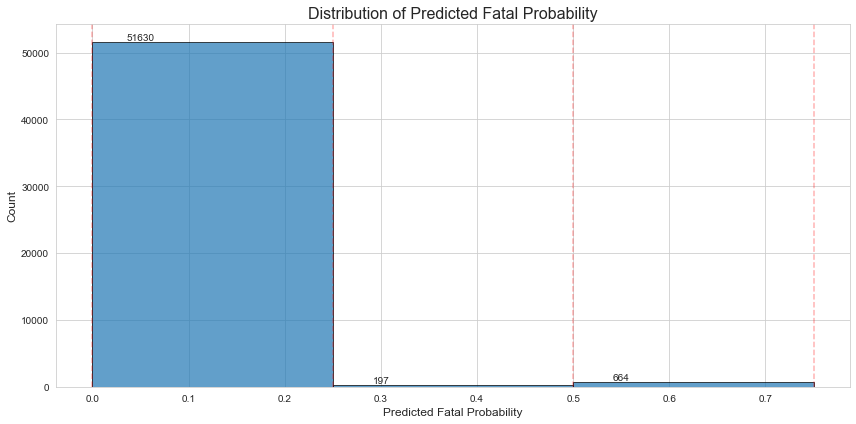

Total count in histogram: 52491


In [44]:
# Create the plot
plt.figure(figsize=(12, 6))

# Create histogram
counts, bins, _ = plt.hist(df['Predicted_Fatal_Probability'], bins=np.arange(0, 1, 0.25), 
                           edgecolor='black', alpha=0.7)

# Customize the plot
plt.title('Distribution of Predicted Fatal Probability', fontsize=16)
plt.xlabel('Predicted Fatal Probability', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels on top of each bar
for i, count in enumerate(counts):
    plt.text(bins[i] + 0.05, count, f'{int(count)}', ha='center', va='bottom')

# Add vertical lines for every 0.1 interval
for i in np.arange(0., 1, 0.25):
    plt.axvline(x=i, color='red', linestyle='--', alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

# Print total count
print(f"Total count in histogram: {int(sum(counts))}")

In [46]:
df.head()

,Year,Month,Day,Weekend?,Hour,Collision Type,Injury Type,Primary Factor,Reported_Location,Latitude,Longitude,Fatal,Predicted_Fatal_Probability,Predicted_Fatal
0,2015,1,5,Weekday,0.0,2-Car,No injury/unknown,OTHER (DRIVER) - EXPLAIN IN NARRATIVE,1ST & FESS,39.159207,-86.525874,0,0.01,0
1,2015,1,6,Weekday,1500.0,2-Car,No injury/unknown,FOLLOWING TOO CLOSELY,2ND & COLLEGE,39.161440,-86.534848,0,0.04,0
2,2015,1,6,Weekend,2300.0,2-Car,Non-incapacitating,DISREGARD SIGNAL/REG SIGN,BASSWOOD & BLOOMFIELD,39.149780,-86.568890,0,0.03,0
3,2015,1,7,Weekend,900.0,2-Car,Non-incapacitating,FAILURE TO YIELD RIGHT OF WAY,GATES & JACOBS,39.165655,-86.575956,0,0.00,0
4,2015,1,7,Weekend,1100.0,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,W 3RD,39.164848,-86.579625,0,0.00,0
